# Stima della distribuzione normale

Data una distribuzione $\mathcal{N}(x;\mu, \sigma)$ gli stimatori non polarizzati di di media e varianza a partire da $N$ campioni $x_i$ si ottengono come segue:

- $\hat{\mu}_N=\frac{1}{N}\sum\limits_{i=0}^{N-1}x_i$
- $\hat{\sigma}^2_N=\frac{1}{(N - 1)}\sum\limits_{i=0}^{N-1}(x_i-\hat{\mu}_N)^2$

In [8]:
import numpy as np
from numpy.random import default_rng
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def plot_estimate(mu, sigma, mu_hat, sigma_hat, data, num_data):
    plt.figure(figsize=(10,10))

    plt.minorticks_on()
    
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 300)

    y = multivariate_normal([mu],[sigma**2])
    y_hat = multivariate_normal([mu_hat],[sigma_hat])

    plt.scatter(data,np.zeros((num_data,)),marker='x',c='r',label='Campioni selezionati')
    plt.plot(x,y.pdf(x),label='Distribuzione teorica')
    plt.plot(x,y_hat.pdf(x),label='Distribuzione stimata')

    plt.text(-0.5,0.45,f'Media stimata: {mu_hat:4.2f}\nVarianza stimata: {sigma_hat:4.2f}\nMSE: {np.sum((y.pdf(data)-y_hat.pdf(data))**2)/num_data:6.4f}',fontsize=14)

    plt.legend()

    plt.show()



## Campionamento uniforme

Genereremo un $N$ campioni in $\left[\mu - 3\sigma,\mu + 3\sigma\right]$ con distribuzione uniforme e utilizzeremo gli stimatori di media e varianza per stimare la distribuzione $\hat{\mathcal{N}}$. Infine valuteremo la bontà della stima tramite il Mean Squared Error:

$MSE = \frac{1}{N}\sum_{i=1}^N \left( \mathcal{N}(x_i) - \hat{\mathcal{N}}(x_i) \right)^2$

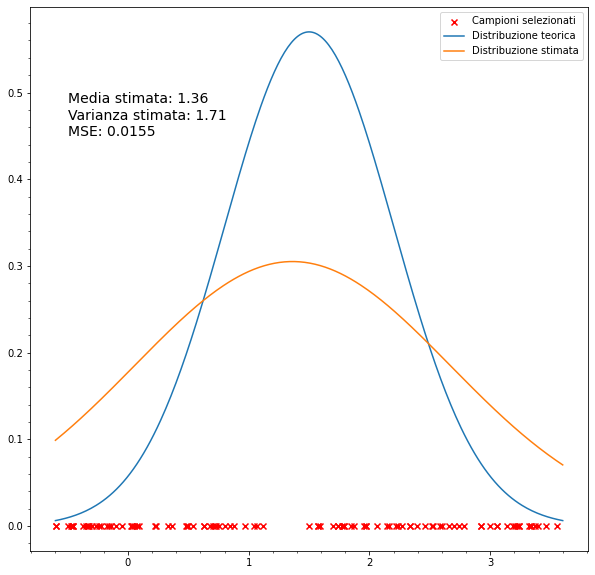

In [9]:
# parametri distribuzione teorica
mu, sigma = 1.5, 0.7

num_data = 100

# generazione di num_data campioni in mu-3sigma, mu+3sigma con distribuzione uniforme
rg = default_rng()
data = rg.uniform(mu - 3*sigma,mu + 3*sigma,num_data)

# stima della media campionaria
mu_hat = np.sum(data)/num_data

# stima della varianza campionaria
sigma_hat = np.sum((data - mu_hat)**2)/(num_data-1)

plot_estimate(mu, sigma, mu_hat, sigma_hat, data, num_data)


# Campionamento stratificato

Useremo sei strati di ampiezza $\sigma$ per ricoprire l'intervallo. Per ognuno di essi,
conosciamo la sua dimensione in termini relativi alla sua numerosità rispetto alla popolazione perché possiamo calcolare semplicememte la probabilità di apparteneneza di un campione ad un dato intervallo come:

$P(x \in [\mu + i\cdot\sigma,\mu+(i+1)\cdot\sigma]) = \int_i^{i+1} \mathcal{N}(x, 0, 1)dx,\ i \in \{-3, -2, \ldots, 2\}$

Questo non è limitante perché nel campionamento stratificato di popolazioni discrete si conosce espressamente la numerosità di ogni strato, oltre a quella di tutto il campione.

Preleveremo un numero di campioni $n_k$ proporzionale alle numerosità di ogni strato.

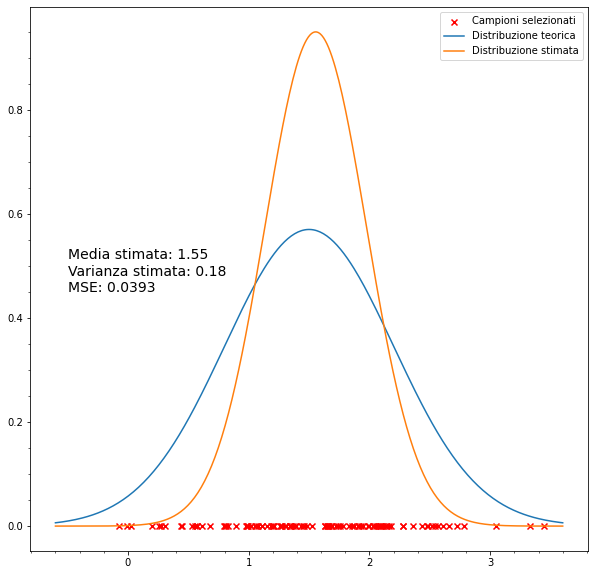

Varianza dello stimatore di media: 0.00036


In [10]:

# arrotondiamo gli estremi a 0.031 perché rimuoviamo le code oltre
# l'intervallo [mu-3sigma, mu+3sigma] che contengono ciascuno l'1% della popolazione
gaussian_population = np.array([0.031, 0.136, 0.341, 0.341, 0.136, 0.031])

num_strata = 6

samples_per_stratum = np.array(num_data*gaussian_population,dtype='int')


data = np.empty((num_data,),dtype='float64')

# vettori delle medie e delle varianze campionarie per strato
mu_per_stratum = np.empty((num_strata,),dtype='float64')
sigma_per_stratum = np.empty((num_strata,),dtype='float64')

i = 0
start = mu - 3*sigma
for k in range(0,len(samples_per_stratum)):
    data[i:i+samples_per_stratum[k]] = rg.uniform(start, start+sigma, samples_per_stratum[k])
    
    # calcolo la media di strato
    mu_per_stratum[k] = np.sum(data[i:i+samples_per_stratum[k]])/samples_per_stratum[k]
    sigma_per_stratum[k] = np.sum((data[i:i+samples_per_stratum[k]]-mu_per_stratum[k])**2)\
                                                                            /(samples_per_stratum[k] - 1)

    i+=samples_per_stratum[k]
    start += sigma

# stima della media stratificata
mu_hat = np.sum(gaussian_population*mu_per_stratum)

# stima della varianza stratificata
sigma_hat = np.sum(sigma_per_stratum)

plot_estimate(mu, sigma, mu_hat, sigma_hat, data, num_data)

print(f'Varianza dello stimatore di media: {np.sum((gaussian_population**2)*sigma_per_stratum/samples_per_stratum):7.5f}')


## Campionamento per importanza

Nel campionamento per importanza, la scelta della funzione importanza $q(\cdot)$ è fondamentale. La teoria ci assicura che una versione scalata della distribuzione da approssimare è un'ottima scelta, ma dipende criticamente dal valore della costante di scaling.

Useremo cpme funzione importanza, la versione scalata della distribuzione $\mathcal{N}(x,\hat{\mu}_N,\hat{\sigma}_N)$ ottenuta da un campionamento uniforme dell'intervallo $\left[\mu - 3\sigma,\mu + 3\sigma\right]$. Possiamo ipotizzare di effettuare uno scaling perché sappiamo già che la stima un campionamento uniforme ha un MSE elevato.

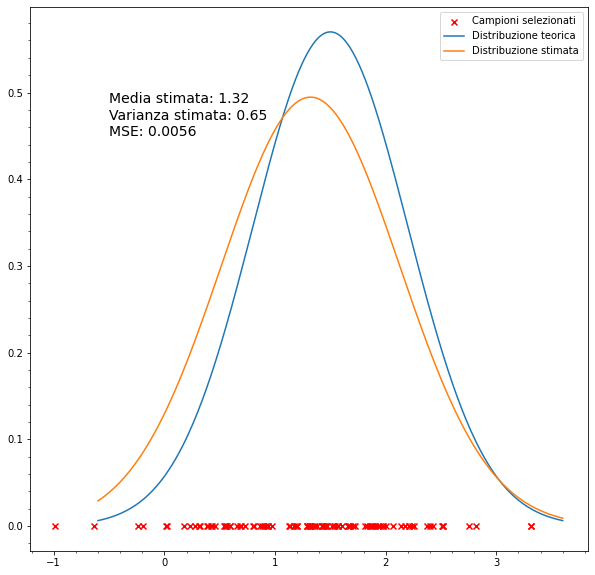

In [11]:


# generazione di num_data campioni in mu-3sigma, mu+3sigma con distribuzione uniforme
# per stimare la funzione importanza
rg = default_rng()
samples_importance = rg.uniform(mu - 3*sigma,mu + 3*sigma,num_data)

# stima della media campionaria
mu_importance = np.sum(samples_importance)/num_data

# stima della varianza campionaria
sigma_importance = np.sum((samples_importance - mu_importance)**2)/(num_data-1)

# usiamo una versione scalata della distribuzione stimata come funzione importanza
data = rg.normal(mu_importance, 0.6*np.sqrt(sigma_importance),num_data)

# stima della media campionaria
mu_hat = np.sum(data)/num_data

# stima della varianza campionaria
sigma_hat = np.sum((data - mu_hat)**2)/(num_data-1)

plot_estimate(mu, sigma, mu_hat, sigma_hat, data, num_data)
